### A Gaussian Process Approach to Geomagnetic Storm Prediction 

Here we build a forecasting model using L1 data as features from the DSCOVR satellite to predict planetary K index (Kp)

In [15]:
#import modules
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, ConstantKernel as C, Product

## Load Data

Load data provided by Nasa, then resample from minute-wise data to hour-wise data, such that historical Kp data can be appended to the dataframe. 

In [16]:
data = pd.read_csv("dsc_fc_summed_spectra_2023_v01 2.csv", \
delimiter = ',', parse_dates=[0], \
infer_datetime_format=True, na_values='0', \
header = None)

data[0] = pd.to_datetime(data[0], format='%Y-%m-%d %H:%M:%S')

# Set date column as index
data.set_index(0, inplace=True)

# Resample and calculate mean for each hour
hourly_data = data.resample('H').mean()

kp_data = pd.read_csv("KP Data.csv")

# Assuming that 'day' column represents the day of the year (1-365/366), convert it to a proper datetime object
kp_data['date'] = kp_data.apply(lambda row: pd.Timestamp(year=int(row['Year']), month=1, day=1) + pd.Timedelta(days=int(row['Day'])-1, hours=int(row['Hour'])), axis=1)

# Set the new 'date' column as the index
kp_data.set_index('date', inplace=True)

hourly_data_2023 = hourly_data.loc['2023']
kp_data_2023 = kp_data.loc['2023']

data = merged_data = pd.merge(hourly_data_2023, kp_data_2023['Kp'], left_index=True, right_index=True, how='left')
merged_data_imputed = merged_data.fillna(merged_data.median()) #Impute missing values with median 

df = merged_data_imputed

Now make the training and testing data frames. Using sklearn scaler to get scaled values (important for model performance)

In [17]:
# Extracting features and target
X = df.iloc[:, 3:53].values  # Columns 4-53 as features
y = df['Kp'].values    # Kp index as target

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Standardize the data (very important for neural networks)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler().fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)


# Feature decomposition

here we use PCA to decompose the space of features to improve effeciency

In [19]:
n_components = 15  # or another value depending on your choice
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


### Design Model

Here we design our gaussian process model

In [20]:
# Define individual kernels
k1 = C() * RBF()
k2 = C() * ExpSineSquared()

# Combining kernels: can use summation or product based on the data characteristics
kernel = C(1.0, (1e-3, 1e4)) * RBF(10, (1e-2, 1e3)) 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha = 0.01)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train_pca, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X_test_pca, return_std=True)

Visaulise Data

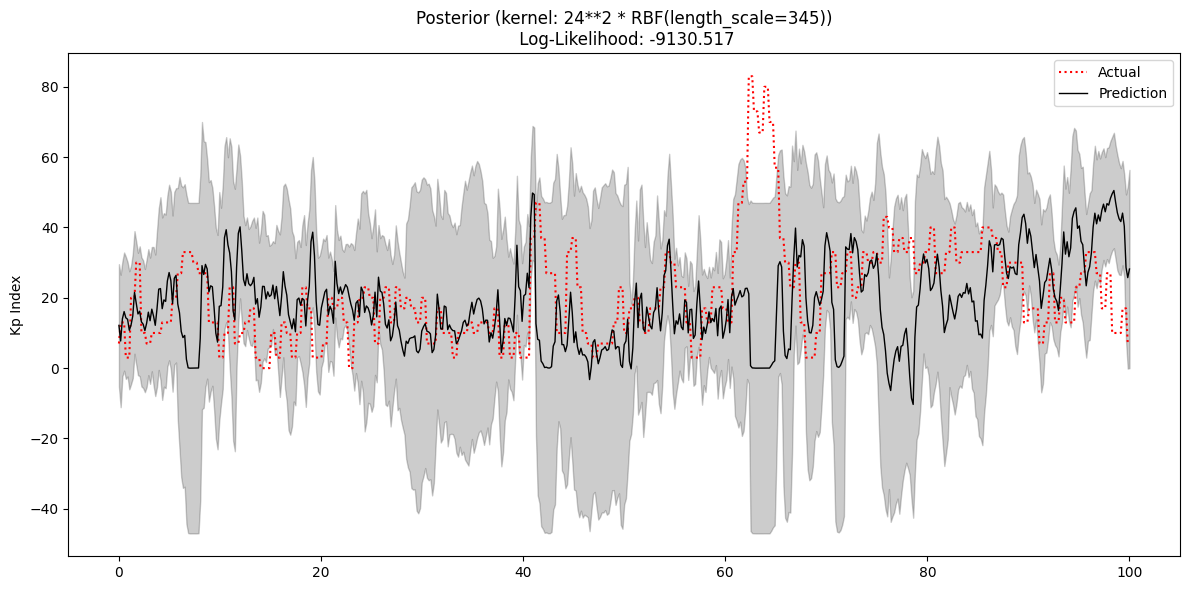

In [108]:
import matplotlib.pyplot as plt

x = np.linspace(0, 100, len(y_pred))

# Assume `datetime_index_test` as your time or sample index for test data
plt.figure(figsize=(12, 6))
plt.plot(x, y_test, 'r:', label='Actual')
plt.plot(x, y_pred, 'k', lw=1, zorder=9, label='Prediction')
plt.fill_between(x, y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='k')
plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
          % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
          fontsize=12)
plt.ylabel('Kp Index')
plt.tight_layout()
plt.legend()
plt.show()

### Forecasting

Building a forecasting model using Gaussian Processes (GPs) that predicts the Kp index z hours into the future based on current and past measurements introduces a temporal aspect to the problem. For time-series forecasting with GPs, we consider temporal dependencies and feature engineering becomes crucial.

We create lag features to incorporate past information in the model, considering the temporal dependencies in the Kp index. For forecasting Kp z hours ahead:

Create lag features: The current and past x hours' features and Kp values as input features.
Target variable: The Kp index z hours ahead.

In [22]:

# `data_X` is the data related to columns 4-53

# Step 1: Feature Engineering
def create_lags(data_X, data_y, lags=5, forecast_horizon=1):
    X, y = [], []
    for i in range(lags, len(data_X) - forecast_horizon):
        X.append(data_X.iloc[i-lags:i].values.flatten())
        y.append(data_y.iloc[i + forecast_horizon - 1])
    return np.array(X), np.array(y)

lags = 5  # Number of past hours to use
forecast_horizon = 16  # Number of hours ahead to forecast
data_X, data_y = create_lags(df.iloc[:, 4:54], df['Kp'], lags, forecast_horizon)

# Step 2: Train/Test Split
# Note: Ensure to split the data in a time-series manner.
train_size = int(len(data_X) * 0.8)
X_train, X_test = data_X[:train_size], data_X[train_size:]
y_train, y_test = data_y[:train_size], data_y[train_size:]

# Fit the GP model
gp.fit(X_train, y_train)

# Predict using the trained GP model
y_pred, sigma = gp.predict(X_test, return_std=True)

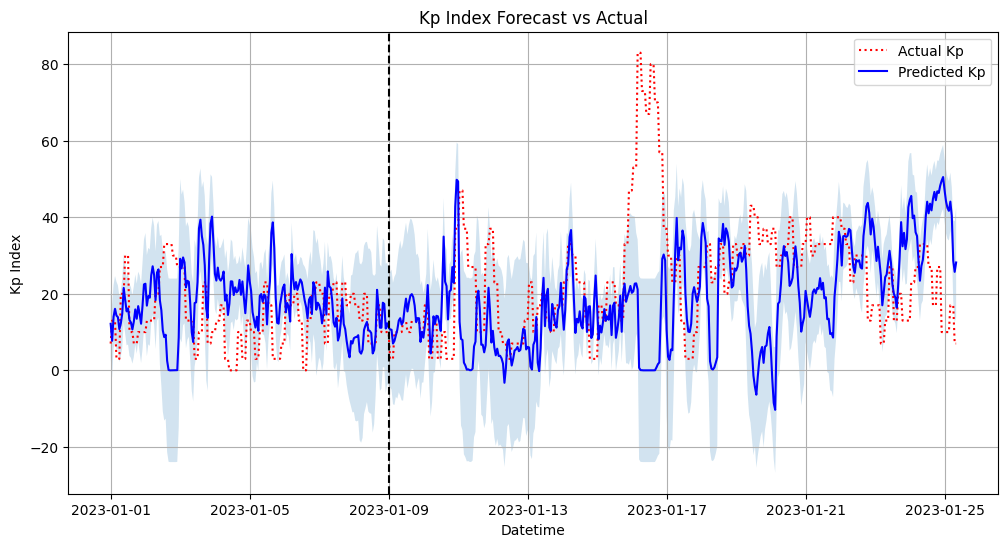

In [66]:
import matplotlib.pyplot as plt

# Define the datetime index for the test set
# You must adjust this according to your specific date-time information and ensure it matches the length of y_test.
# For example:
datetime_index_test = df.index[0:len(y_test)]

# Assuming y_test and y_pred are your actual and predicted Kp index values respectively, and they are in the proper time order.

# Simple Line Plot
plt.figure(figsize=(12, 6))
plt.plot(datetime_index_test, y_test, 'r:', label='Actual Kp')
plt.plot(datetime_index_test, y_pred, 'b-', label='Predicted Kp')
plt.axvline(datetime_index_test[192], color='k', linestyle='--')
plt.fill_between(datetime_index_test, y_pred - sigma, y_pred + sigma, alpha=0.2)
plt.xlabel('Datetime')
plt.ylabel('Kp Index')
plt.title('Kp Index Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()
